In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import glob, os
import matplotlib as mpl
from shapely.geometry import Point, Polygon

<AxesSubplot:>

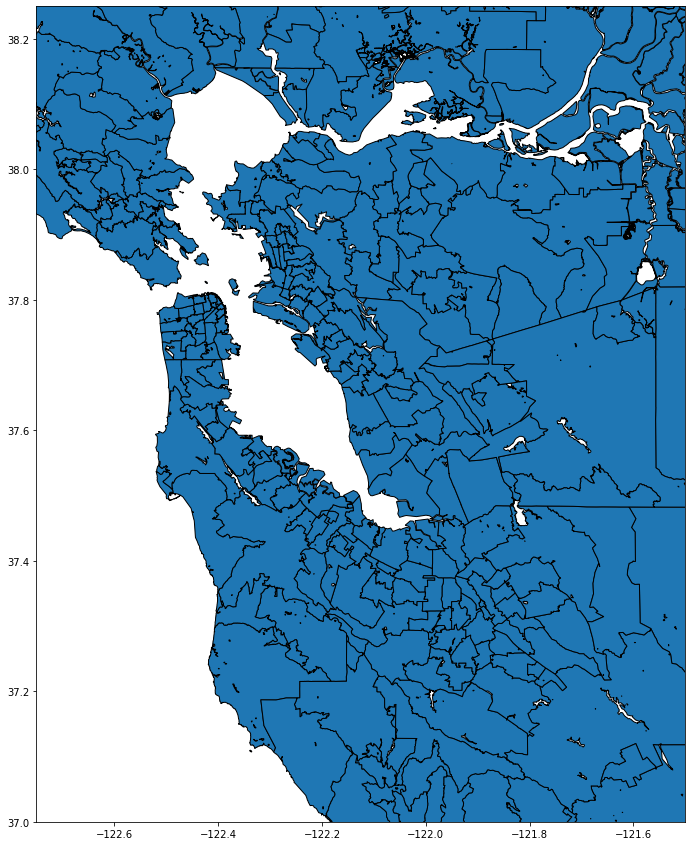

In [2]:
# Create the basemap of the area. The original shapefile are census areas in the bay area.
# Also need .shx and .prj files in the same folder
census_map = gpd.read_file('TG00CAZCTA.shp')

# The census map's shapefile is using UTM coordinates for all the points. This changes the 
# Coordinate Reference System to WGS84 lat/lon, which is what the radiosonde telemetry is in
census_map = census_map.to_crs('EPSG:4326')

# Create a plot, set some lat/long limits, and plot it
fig,ax = plt.subplots(figsize = (15,15))
ax.set_ylim([37, 38.25])
ax.set_xlim([-122.75, -121.5])
census_map.plot(ax = ax, linewidth=1, edgecolor='black')

In [3]:
# Create a pandas dataframe from all the radiosonde .log files that are in the "log" directory
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('log/', "*.log"))))

# Print the dataframe so we can see it. Jupyter only plots a few lines (thankfully)
print(df)

                    timestamp    serial  frame       lat        lon      alt  \
0    2020-11-09T11:10:53.001Z  S1410692   1939  37.72754 -122.22489   1661.2   
1    2020-11-09T11:10:54.001Z  S1410692   1940  37.72748 -122.22484   1667.9   
2    2020-11-09T11:10:55.001Z  S1410692   1941  37.72742 -122.22481   1675.9   
3    2020-11-09T11:10:56.001Z  S1410692   1942  37.72735 -122.22479   1684.2   
4    2020-11-09T11:11:00.001Z  S1410692   1946  37.72706 -122.22473   1707.5   
..                        ...       ...    ...       ...        ...      ...   
318  2020-11-06T12:59:40.001Z  S1340579   6887  38.04457 -121.23972  34353.5   
319  2020-11-06T12:59:53.001Z  S1340579   6900  38.04385 -121.23921  34426.9   
320  2020-11-06T12:59:54.001Z  S1340579   6901  38.04383 -121.23914  34414.4   
321  2020-11-06T13:00:25.001Z  S1340579   6932  38.04180 -121.23753  33271.3   
322  2020-11-06T13:00:26.001Z  S1340579   6933  38.04174 -121.23738  33239.4   

     vel_v  vel_h  heading   temp  humi

In [4]:
# Here we can look at the minimum value in the "snr" column
minsnr = df["snr"].min()
print('Minimum SNR: %f' % minsnr)

Minimum SNR: 5.800000


In [5]:
# Here we can look at the max value in the "alt" column, max altitude packet received
maxalt = df["alt"].max()
print('Max altitude: %d' % maxalt)

Max altitude: 37107


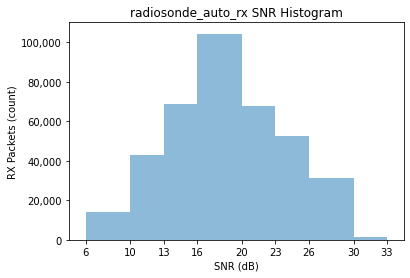

In [6]:
# Create a series (list) from the "snr" field of the pandas dataframe
snrhist = df["snr"]

# Plot the histogram, with the bins below
ax = snrhist.plot.hist(bins=[6,10,13,16,20,23,26,30,33], alpha=0.5, color='tab:blue')

# Add comma thousands separator for the Y-axis
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add some nice formatting for the plot
plt.xticks([6,10,13,16,20,23,26,30,33])
plt.xlabel('SNR (dB)')
plt.ylabel('RX Packets (count)')
plt.title('radiosonde_auto_rx SNR Histogram')
plt.ylim(ymin=0, ymax=110000)
plt.xlim(xmin=4.5, xmax=34.5)

# Save the figure locally
plt.savefig('snr.jpg', bbox_inches='tight')

In [7]:
# Create geometry points from the lat/lon in the pandas dataframe
geometry = [Point(xy) for xy in zip( df["lon"], df["lat"]) ]
geometry[:3]

In [8]:
# Create a geopandas dataframe, using the pandas dataframe and the geometry points
geo_df = gpd.GeoDataFrame(df,                  #specify dataframe used
                         crs = 'EPSG:4326',    #specify coordinate ref system
                         geometry = geometry)  #use the lat/long point list created

# Show snippet of this new geo dataframe
geo_df.head()

timestamp    serial  frame       lat        lon     alt  \
0  2020-11-09T11:10:53.001Z  S1410692   1939  37.72754 -122.22489  1661.2   
1  2020-11-09T11:10:54.001Z  S1410692   1940  37.72748 -122.22484  1667.9   
2  2020-11-09T11:10:55.001Z  S1410692   1941  37.72742 -122.22481  1675.9   
3  2020-11-09T11:10:56.001Z  S1410692   1942  37.72735 -122.22479  1684.2   
4  2020-11-09T11:11:00.001Z  S1410692   1946  37.72706 -122.22473  1707.5   

   vel_v  vel_h  heading   temp  humidity  type  freq_mhz  snr  f_error_hz  \
0    7.2    8.4    151.5 -273.0      -1.0  RS41   404.001  8.1        -187   
1    7.2    8.1    151.8 -273.0      -1.0  RS41   404.001  9.3        -187   
2    8.5    7.4    163.5 -273.0      -1.0  RS41   404.001  9.3        -187   
3    8.6    6.5    173.5 -273.0      -1.0  RS41   404.001  9.1        -187   
4    5.3   10.9    163.5 -273.0      -1.0  RS41   404.001  9.4        -187   

   sats  batt_v burst_timer  aux_data                     geometry  
0     7     2.9          -1        -1  POINT (-122.22489 37.72754)  
1     7     2.9          -1        -1  POINT (-122.22484 37.72748)  
2     7     2.9          -1        -1  POINT (-122.22481 37.72742)  
3     7     2.9          -1        -1  POINT (-122.22479 37.72735)  
4     7     2.9          -1        -1  POINT (-122.22473 37.72706)

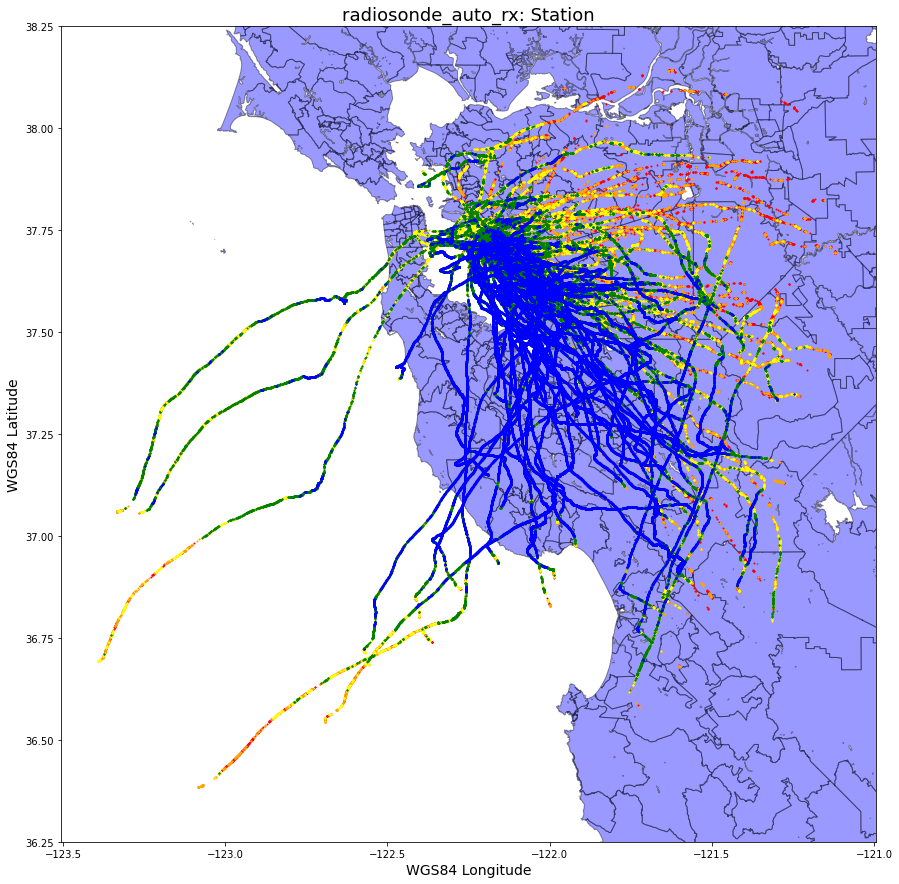

In [9]:
# OK, let's finally plot this geopandas dataframe!
# First off, create the underlying map
fig,ax = plt.subplots(figsize = (15,15))
ax.set_box_aspect(1)
ax.set_ylim([36.25, 38.25])
ax.set_xlim([-123.5, -121.0])
ax.set_ylabel('WGS84 Latitude', fontsize=14)
ax.set_xlabel('WGS84 Longitude', fontsize=14)
ax.set_title('radiosonde_auto_rx: Station', fontsize=18)
census_map.plot(ax = ax, alpha = 0.4, color="blue", linewidth=1, edgecolor='black')

# This next part slices up the geo dataframe based on SNR value bin.
# The new geo_df1 has all the points with SNR greater than 10 (including SNR > 20). And so on.
geo_df1 = geo_df[geo_df['snr'] >= 10]
geo_df2 = geo_df1[geo_df1['snr'] >= 13]
geo_df3 = geo_df2[geo_df2['snr'] >= 16]
geo_df4 = geo_df3[geo_df3['snr'] >= 20]

# Trim out the values above the bin. Now geo_df only has values below SNR 10.
# geo_df1 has SNR > 10 (from above), now trim out SNR > 13, so you only get 10 to 13
geo_df = geo_df[geo_df['snr'] < 10]
geo_df1 = geo_df1[geo_df1['snr'] < 13]
geo_df2 = geo_df2[geo_df2['snr'] < 16]
geo_df3 = geo_df3[geo_df3['snr'] < 20]

# Plot these points.
geo_df.plot(ax = ax, markersize = 1, color = "red", marker = "o")
geo_df1.plot(ax = ax, markersize = 1, color = "orange", marker = "o")
geo_df2.plot(ax = ax, markersize = 1, color = "yellow", marker = "o")
geo_df3.plot(ax = ax, markersize = 1, color = "green", marker = "o")
geo_df4.plot(ax = ax, markersize = 1, color = "blue", marker = "o")

# Save the figure (if you don't crash jupyter)
# I added the legend copy/paste with gimp
plt.savefig('map.jpg', bbox_inches='tight')